# Capstone Phase 2 - ANN  
Exploration of Artificial Neural Networks

### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Some Utility Stuff

In [2]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [3]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [4]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

Print search results code from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [5]:
def print_search_results(gs_results):
  print("Best: %f using %s" % (gs_results.best_score_, gs_results.best_params_))
  means = gs_results.cv_results_['mean_test_score']
  stds = gs_results.cv_results_['std_test_score']
  params = gs_results.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
  return

### Load data and apply transformations

We need to upload the data file from our local drive.

In [6]:
from google.colab import files
uploaded = files.upload()

Saving UNSW_NB15 training and testing sets.zip to UNSW_NB15 training and testing sets.zip


Import the io library so we can load the file we uploaded.

In [7]:
import io

In [8]:
with ZipFile(io.BytesIO(uploaded['UNSW_NB15 training and testing sets.zip'])) as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [9]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [10]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [11]:
class_names = list(label_encoder.classes_)

### Load feature subsets

First upload the file from our local drive

In [12]:
features_pkl = files.upload() # joblib.load('./data/feature_subsets.pkl')

Saving feature_subsets.pkl to feature_subsets.pkl


In [13]:
feature_subsets = joblib.load('feature_subsets.pkl')

In [14]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

### Artificial Neural Network  
We'll start with a basic sequential model.

In [15]:
import tensorflow as tf
from tensorflow import keras

We're going to start with a basic Sequential network with following connected layers using ReLU activation.  Because we're doing multiclassification we'll use softmax activation on the output layer.  

A. Géron, “Chapter 10: Introduction to Artificial Neural Networks with Keras,” in Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems, 2nd ed., Sebastopol, CA: O'Reilly Media, Inc., 2019, p. 299. 

In [ ]:
model = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(300, activation='relu'),
                                 keras.layers.Dense(100, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 37,410
Trainable params: 37,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 7s 2ms/step - loss: 1.0658 - accuracy: 0.6178 - val_loss: 0.4872 - val_accuracy: 0.8502
Epoch 2/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.7711 - accuracy: 0.7162 - val_loss: 0.4433 - val_accuracy: 0.8625
Epoch 3/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.7256 - accuracy: 0.7350 - val_loss: 0.4182 - val_accuracy: 0.8731
Epoch 4/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.7006 - accuracy: 0.7401 - val_loss: 0.4113 - val_accuracy: 0.8746
Epoch 5/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6897 - accuracy: 0.7437 - val_loss: 0.3910 - val_accuracy: 0.8776
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6684 - accuracy: 0.7481 - val_loss: 0.3770 - val_accuracy: 0.8843
Epoch 7/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6623 - accuracy: 0.7480 - val_loss: 0.3716 - val_accuracy:

In [ ]:
import seaborn as sns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

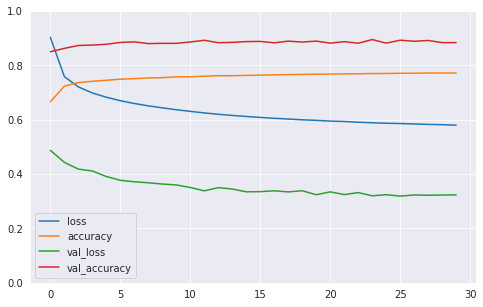

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-1-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-1-learning-curves.png')
plt.show()

In [ ]:
model.save('sequential1.h5')
files.download('sequential1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These results look very good for a quick test.  But there is something strange going on, because the validation accuracy is higher than training, and validation loss is much lower than training.  This might be because the network is too large for the data set.  We used 2 layers with 300, and 100 nodes, but we only used 20 features from the data set.  We should try a smaller network for smaller feature sets.  
Of course we'll also want to tune the hyper-parameters.  The training set is skewed so we should set `class_weight`.  
For comparison to the other models we'll want to train on each feature subset, but ultimately we want to see what we can do with the full set.

Let's see what happens with fewer nodes.

In [ ]:
model2 = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(20, activation='relu'),
                                 keras.layers.Dense(15, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 6s 1ms/step - loss: 1.1836 - accuracy: 0.5725 - val_loss: 0.5260 - val_accuracy: 0.8357
Epoch 2/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.8185 - accuracy: 0.6958 - val_loss: 0.4694 - val_accuracy: 0.8667
Epoch 3/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7609 - accuracy: 0.7163 - val_loss: 0.4407 - val_accuracy: 0.8683
Epoch 4/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7399 - accuracy: 0.7282 - val_loss: 0.4238 - val_accuracy: 0.8786
Epoch 5/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7232 - accuracy: 0.7336 - val_loss: 0.4116 - val_accuracy: 0.8813
Epoch 6/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7112 - accuracy: 0.7365 - val_loss: 0.4032 - val_accuracy: 0.8813
Epoch 7/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7000 - accuracy: 0.7384 - val_loss: 0.3944 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

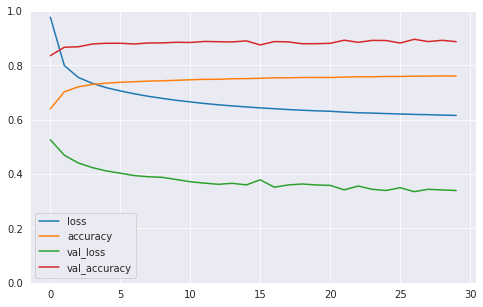

In [ ]:
pd.DataFrame(hist2.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-2-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-2-learning-curves.png')
plt.show()

In [ ]:
model2.save('sequential2.h5')
files.download('sequential2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Even with far fewer nodes we still see the same behavior.  A little more investigation is called for.

The issue may be with the training/validation split.  The 20% `validation_split` may not be representative of the full data set.  It's probably better to use k-fold cross-validation.  That's also what we did for the other models we've trained.

In [ ]:
model3 = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(18, activation='relu'),
                                 keras.layers.Dense(15, activation='relu'),
                                 keras.layers.Dense(12, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
hist3 = model3.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.9935 - accuracy: 0.6500 - val_loss: 0.4117 - val_accuracy: 0.8798
Epoch 2/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6939 - accuracy: 0.7386 - val_loss: 0.3862 - val_accuracy: 0.8829
Epoch 3/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6630 - accuracy: 0.7489 - val_loss: 0.3652 - val_accuracy: 0.8835
Epoch 4/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6416 - accuracy: 0.7535 - val_loss: 0.3522 - val_accuracy: 0.8838
Epoch 5/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6300 - accuracy: 0.7562 - val_loss: 0.3404 - val_accuracy: 0.8861
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6219 - accuracy: 0.7606 - val_loss: 0.3388 - val_accuracy: 0.8888
Epoch 7/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6197 - accuracy: 0.7617 - val_loss: 0.3405 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

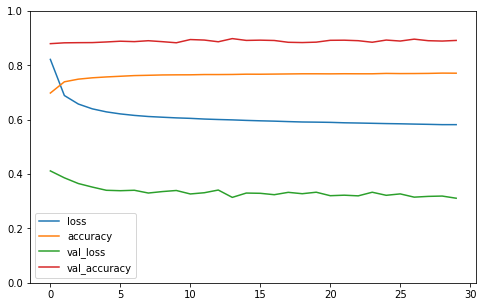

In [ ]:
pd.DataFrame(hist3.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-3-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-3-learning-curves.png')
plt.show()

In [ ]:
model3.save('sequential3.h5')
files.download('sequential3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adding more layers and changing the optimizer to 'Adam' improves training accuracy and loss. Validation accuracy and loss remain about the same. Perhaps cross-validation will make a difference, but maybe we just need to tune the parameters.

### More Features

Let's try one with a larger feature set.

In [16]:
sorted_features_pkl = files.upload() # joblib.load('./data/rfb3_sorted_feature_importances.pkl')

Saving rfb3_sorted_feature_importances.pkl to rfb3_sorted_feature_importances.pkl


In [17]:
sorted_features = joblib.load('rfb3_sorted_feature_importances.pkl')

In [18]:
top_feats = [x[0] for x in sorted_features if x[1] > 1e-3]

In [19]:
train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [20]:
len(top_feats)

50

In [ ]:
model4 = keras.models.Sequential([keras.layers.Input(shape=train_std_RF.shape[1:]),
                                 keras.layers.Dense(48, activation='relu'),
                                 keras.layers.Dense(36, activation='relu'),
                                 keras.layers.Dense(24, activation='relu'),
                                 keras.layers.Dense(12, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# we're using Sparse Categorical Cross-entropy loss b/c the labels are integers, not one-hot vectors
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist4 = model4.fit(train_std_RF, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.8139 - accuracy: 0.6976 - val_loss: 0.3138 - val_accuracy: 0.8962
Epoch 2/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6051 - accuracy: 0.7584 - val_loss: 0.3072 - val_accuracy: 0.8964
Epoch 3/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.5791 - accuracy: 0.7665 - val_loss: 0.3017 - val_accuracy: 0.8919
Epoch 4/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5680 - accuracy: 0.7716 - val_loss: 0.2902 - val_accuracy: 0.9041
Epoch 5/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5615 - accuracy: 0.7748 - val_loss: 0.2826 - val_accuracy: 0.9047
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5561 - accuracy: 0.7742 - val_loss: 0.2965 - val_accuracy: 0.8906
Epoch 7/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5511 - accuracy: 0.7761 - val_loss: 0.2782 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

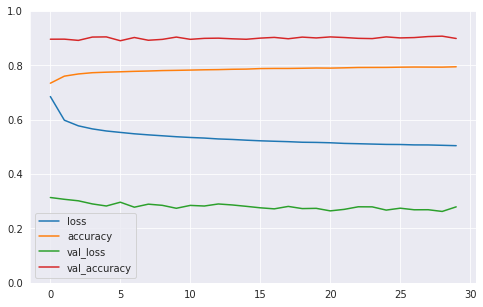

In [ ]:
pd.DataFrame(hist4.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-4-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-4-learning-curves.png')
plt.show()

In [ ]:
model4.save('sequential4.h5')
files.download('sequential4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

More features and a larger network lead to improved training and validation accuracy and loss. It's probably time to do some grid-searching to tune the parameters of these networks.

So far, these networks seem to reach their best accuracy around 10-15 epochs of training. Should probably just implement eary stopping to avoid wasting time.

## RandomizedSearchCV/GridSearchCV

Let's define a function to build models so we can wrap the model for use in Scikit-Learn functions, i.e. GridSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
def build_seq_model(input_shape, num_layers=1, num_neurons=20, lr=0.001, activation='relu',
                    loss_func='sparse_categorical_crossentropy', metrics=['accuracy']):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  for layer in range(num_layers):
    model.add(keras.layers.Dense(num_neurons, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  optimizer = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)
  return model

In [ ]:
def build_seq_model_2(input_shape, lr=0.001, activation='relu', optimizer='Adam',
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(48, activation=activation))
  model.add(keras.layers.Dense(36, activation=activation))
  model.add(keras.layers.Dense(24, activation=activation))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  model.compile(loss=loss_func, optimizer=optimizer, metrics=['accuracy'])
  return model

### Layers and Neurons

In [ ]:
params = {'num_layers':[1,2,3,4,5], 'num_neurons':np.arange(1,50)}

In [ ]:
seq_model_1 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model, input_shape=train_std_RF.shape[1:])

In [ ]:
rand_search_1 = RandomizedSearchCV(seq_model_1, params, n_iter=10, cv=3)

In [ ]:
rand_search_1.fit(train_std_RF, y_train, epochs=100, validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
2923/2923 [==============================] - 6s 2ms/step - loss: 1.3842 - accuracy: 0.5030 - val_loss: 0.3540 - val_accuracy: 0.9040
Epoch 2/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.9220 - accuracy: 0.6742 - val_loss: 0.3360 - val_accuracy: 0.9061
Epoch 3/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.8888 - accuracy: 0.6875 - val_loss: 0.3228 - val_accuracy: 0.9077
Epoch 4/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.8754 - accuracy: 0.6898 - val_loss: 0.3228 - val_accuracy: 0.9056
Epoch 5/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.8653 - accuracy: 0.6922 - val_loss: 0.3173 - val_accuracy: 0.9077
Epoch 6/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.8470 - accuracy: 0.6963 - val_loss: 0.3056 - val_accuracy: 0.9086
Epoch 7/100
2923/2923 [==============================] - 5s 2ms/step - loss: 0.8327 - accuracy: 0.7006 - val_loss: 0.3046 - val_ac

RuntimeError: ignored

In [ ]:
rand_search_1.best_params_

{'num_layers': 4, 'num_neurons': 6}

In [ ]:
rand_search_1.best_score_

0.44229814410209656

Try something else...

In [ ]:
model5 = keras.models.Sequential([keras.layers.Input(shape=train_std_RF.shape[1:]),
                                 keras.layers.Dense(50, activation='relu'),
                                 keras.layers.Dense(50, activation='relu'),
                                 keras.layers.Dense(50, activation='relu'),
                                 keras.layers.Dense(50, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist5 = model5.fit(train_std_RF, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
4384/4384 [==============================] - 11s 2ms/step - loss: 0.7659 - accuracy: 0.7047 - val_loss: 0.3078 - val_accuracy: 0.8911
Epoch 2/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5955 - accuracy: 0.7619 - val_loss: 0.3033 - val_accuracy: 0.8933
Epoch 3/20
4384/4384 [==============================] - 9s 2ms/step - loss: 0.5738 - accuracy: 0.7684 - val_loss: 0.2935 - val_accuracy: 0.8972
Epoch 4/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5551 - accuracy: 0.7744 - val_loss: 0.2944 - val_accuracy: 0.8938
Epoch 5/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5475 - accuracy: 0.7781 - val_loss: 0.2725 - val_accuracy: 0.9049
Epoch 6/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5395 - accuracy: 0.7784 - val_loss: 0.2882 - val_accuracy: 0.8944
Epoch 7/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5412 - accuracy: 0.7785 - val_loss: 0.2906 - val_acc

In [ ]:
model5.save('sequential5.h5')
files.download('sequential5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
seq_model_2 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model, input_shape=train_std_RF.shape[1:])

In [ ]:
params2 = {'num_layers':[3,4,5], 'num_neurons':[20,30,40,50]}

In [ ]:
rand_search_2 = RandomizedSearchCV(seq_model_2, params2, n_iter=10, cv=3)

In [ ]:
rand_search_2.fit(train_std_RF, y_train, epochs=20, validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
2923/2923 [==============================] - 8s 3ms/step - loss: 1.0017 - accuracy: 0.6451 - val_loss: 0.2707 - val_accuracy: 0.9127
Epoch 2/20
2923/2923 [==============================] - 7s 3ms/step - loss: 0.7600 - accuracy: 0.7109 - val_loss: 0.2526 - val_accuracy: 0.9177
Epoch 3/20
2923/2923 [==============================] - 6s 2ms/step - loss: 0.7244 - accuracy: 0.7227 - val_loss: 0.2528 - val_accuracy: 0.9157
Epoch 4/20
2923/2923 [==============================] - 6s 2ms/step - loss: 0.7071 - accuracy: 0.7293 - val_loss: 0.2465 - val_accuracy: 0.9168
Epoch 5/20
2923/2923 [==============================] - 6s 2ms/step - loss: 0.6996 - accuracy: 0.7322 - val_loss: 0.2375 - val_accuracy: 0.9193
Epoch 6/20
2923/2923 [==============================] - 6s 2ms/step - loss: 0.6901 - accuracy: 0.7331 - val_loss: 0.2359 - val_accuracy: 0.9202
Epoch 7/20
2923/2923 [==============================] - 6s 2ms/step - loss: 0.6794 - accuracy: 0.7361 - val_loss: 0.2313 - val_accuracy:

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6119c07e90>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'num_layers': [3, 4, 5],
                                        'num_neurons': [20, 30, 40, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
rand_search_2.best_params_

{'num_layers': 5, 'num_neurons': 30}

In [ ]:
rand_search_2.best_score_

0.46309763193130493

In [ ]:
rand_search_2.cv_results_

{'mean_fit_time': array([120.19707537, 130.84049177, 119.24766588, 129.05511602,
        152.43514395, 134.92662676, 163.39980857, 156.43728669,
        134.36775374, 173.51560982]),
 'mean_score_time': array([2.35070562, 2.39553157, 2.53060436, 2.51823243, 2.76373919,
        2.80413969, 2.87410164, 2.80936964, 2.88828556, 3.02871792]),
 'mean_test_score': array([0.32395161, 0.32074643, 0.31722758, 0.36674251, 0.46309763,
        0.32849704, 0.34073606, 0.32455616, 0.33052166, 0.33365271]),
 'param_num_layers': masked_array(data=[3, 4, 4, 3, 5, 5, 5, 4, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_num_neurons': masked_array(data=[30, 30, 20, 40, 30, 20, 40, 40, 20, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'num_layers

In [ ]:
best_model = rand_search_2.best_estimator_.model

In [ ]:
best_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_159 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_160 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_161 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_162 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_163 (Dense)            (None, 10)                310       
Total params: 5,560
Trainable params: 5,560
Non-trainable params: 0
___________________________________________________

In [ ]:
best_model.save('sequential_best1.h5')
files.download('sequential_best1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model6 = keras.models.Sequential([keras.layers.Input(shape=train_std_RF.shape[1:]),
                                 keras.layers.Dense(30, activation='relu'),
                                 keras.layers.Dense(30, activation='relu'),
                                 keras.layers.Dense(30, activation='relu'),
                                 keras.layers.Dense(30, activation='relu'),
                                 keras.layers.Dense(30, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist6 = model6.fit(train_std_RF, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.8053 - accuracy: 0.6937 - val_loss: 0.3328 - val_accuracy: 0.8909
Epoch 2/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.6048 - accuracy: 0.7553 - val_loss: 0.2985 - val_accuracy: 0.9011
Epoch 3/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5793 - accuracy: 0.7689 - val_loss: 0.3156 - val_accuracy: 0.8882
Epoch 4/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5693 - accuracy: 0.7708 - val_loss: 0.2978 - val_accuracy: 0.8937
Epoch 5/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5587 - accuracy: 0.7750 - val_loss: 0.2769 - val_accuracy: 0.9059
Epoch 6/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5498 - accuracy: 0.7782 - val_loss: 0.2886 - val_accuracy: 0.8995
Epoch 7/20
4384/4384 [==============================] - 10s 2ms/step - loss: 0.5437 - accuracy: 0.7799 - val_loss: 0.2835 - val_ac

In [ ]:
model6.save('sequential6.h5')
files.download('sequential6.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
params3 = {'num_layers':[3,4,5], 'num_neurons':[30,40,50]}

In [ ]:
seq_model_3 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model, input_shape=train_std_RF.shape[1:])

In [ ]:
rand_search_3 = RandomizedSearchCV(seq_model_3, params3, n_iter=5, cv=3, n_jobs=-1)

In [ ]:
rand_search_3.fit(train_std_RF, y_train, epochs=20)

Epoch 1/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.7096 - accuracy: 0.7416
Epoch 2/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5384 - accuracy: 0.7894
Epoch 3/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5175 - accuracy: 0.7940
Epoch 4/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5033 - accuracy: 0.8000
Epoch 5/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.4970 - accuracy: 0.8007
Epoch 6/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.4915 - accuracy: 0.8029
Epoch 7/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.4894 - accuracy: 0.8033
Epoch 8/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.4838 - accuracy: 0.8059
Epoch 9/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.4782 - accuracy: 0.8067
Epoch 10/20
5480/5480 [==============================] - 10s 2ms/step - l

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f61236b9e50>,
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'num_layers': [3, 4, 5],
                                        'num_neurons': [30, 40, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
rand_search_3.best_params_

{'num_layers': 3, 'num_neurons': 40}

In [ ]:
rand_search_3.best_score_

0.49328450361887616

In [ ]:
rand_search_3.cv_results_

{'mean_fit_time': array([238.80414351, 251.98485955, 219.04415178, 225.73642596,
        168.86347119]),
 'mean_score_time': array([3.38018179, 3.46296581, 3.35361171, 3.30094457, 2.81066426]),
 'mean_test_score': array([0.33065855, 0.3521253 , 0.36998192, 0.32143081, 0.4932845 ]),
 'param_num_layers': masked_array(data=[4, 5, 4, 4, 3],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_num_neurons': masked_array(data=[50, 30, 40, 30, 40],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'num_layers': 4, 'num_neurons': 50},
  {'num_layers': 5, 'num_neurons': 30},
  {'num_layers': 4, 'num_neurons': 40},
  {'num_layers': 4, 'num_neurons': 30},
  {'num_layers': 3, 'num_neurons': 40}],
 'rank_test_score': array([4, 3, 2, 5, 1], dtype=int32),
 'split0_test_score': array([0.1668178 , 0.1684432 , 0.18373911, 0.15704827, 0.16366965]),
 'split1_test_score': ar

In [ ]:
best_model_3 = rand_search_3.best_estimator_.model

In [ ]:
best_model_3.save('sequential_best3.h5')
files.download('sequential_best3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try another

In [ ]:
params4 = {'num_layers':[3,4,5], 'num_neurons':[30,40]}

In [ ]:
seq_model_4 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model, input_shape=train_std_RF.shape[1:])

In [ ]:
rand_search_4 = RandomizedSearchCV(seq_model_4, params4, scoring='accuracy', n_iter=5, cv=3, n_jobs=-1)

In [ ]:
rand_search_4.fit(train_std_RF, y_train, epochs=20)

Epoch 1/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.7404 - accuracy: 0.7344
Epoch 2/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5428 - accuracy: 0.7868
Epoch 3/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5225 - accuracy: 0.7914
Epoch 4/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.5117 - accuracy: 0.7967
Epoch 5/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.5009 - accuracy: 0.8008
Epoch 6/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.4973 - accuracy: 0.8018
Epoch 7/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.4887 - accuracy: 0.8046
Epoch 8/20
5480/5480 [==============================] - 11s 2ms/step - loss: 0.4916 - accuracy: 0.8019
Epoch 9/20
5480/5480 [==============================] - 10s 2ms/step - loss: 0.4855 - accuracy: 0.8057
Epoch 10/20
5480/5480 [==============================] - 10s 2ms/step - l

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6121234410>,
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'num_layers': [3, 4, 5],
                                        'num_neurons': [30, 40]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [ ]:
rand_search_4.best_params_

{'num_layers': 3, 'num_neurons': 30}

In [ ]:
rand_search_4.best_score_

0.32924415852538763

In [ ]:
rand_search_4.cv_results_

{'mean_fit_time': array([204.85960754, 225.09028761, 238.08057062, 248.12533887,
        173.13211139]),
 'mean_score_time': array([2.1517516 , 2.33330226, 2.25818483, 2.26573483, 1.87040679]),
 'mean_test_score': array([0.32924416, 0.32161331, 0.3241056 , 0.31848227, 0.32193269]),
 'param_num_layers': masked_array(data=[3, 4, 5, 5, 3],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_num_neurons': masked_array(data=[30, 30, 40, 30, 40],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'num_layers': 3, 'num_neurons': 30},
  {'num_layers': 4, 'num_neurons': 30},
  {'num_layers': 5, 'num_neurons': 40},
  {'num_layers': 5, 'num_neurons': 30},
  {'num_layers': 3, 'num_neurons': 40}],
 'rank_test_score': array([1, 4, 2, 5, 3], dtype=int32),
 'split0_test_score': array([0.16529505, 0.15896453, 0.16816945, 0.15774976, 0.16004243]),
 'split1_test_score': ar

In [ ]:
best_model_4 = rand_search_4.best_estimator_.model

In [ ]:
best_model_4.save('sequential_best4.h5')
files.download('sequential_best4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optimizer

In [ ]:
params_opt = {'optimizer':['SGD', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']}

In [ ]:
seq_model_opt = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_2, input_shape=train_std_RF.shape[1:], epochs=20)

In [ ]:
grid_search_opt = GridSearchCV(estimator=seq_model_opt, param_grid=params_opt, cv=3, n_jobs=-1)

In [ ]:
gs_opt_result = grid_search_opt.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 1.6849 - accuracy: 0.4663
Epoch 2/20
5480/5480 [==============================] - 7s 1ms/step - loss: 1.0033 - accuracy: 0.6714
Epoch 3/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.8176 - accuracy: 0.7321
Epoch 4/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7635 - accuracy: 0.7442
Epoch 5/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7391 - accuracy: 0.7475
Epoch 6/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7257 - accuracy: 0.7493
Epoch 7/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7068 - accuracy: 0.7525
Epoch 8/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7026 - accuracy: 0.7536
Epoch 9/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.6960 - accuracy: 0.7552
Epoch 10/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.690

In [ ]:
gs_opt_result.best_score_

0.4901078442732493

In [ ]:
gs_opt_result.best_params_

{'optimizer': 'Adagrad'}

In [ ]:
print("Best: %f using %s" % (gs_opt_result.best_score_, gs_opt_result.best_params_))
means = gs_opt_result.cv_results_['mean_test_score']
stds = gs_opt_result.cv_results_['std_test_score']
params = gs_opt_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.490108 using {'optimizer': 'Adagrad'}
0.325725 (0.184883) with: {'optimizer': 'SGD'}
0.447385 (0.212536) with: {'optimizer': 'RMSprop'}
0.331788 (0.202948) with: {'optimizer': 'Adam'}
0.490108 (0.266072) with: {'optimizer': 'Adagrad'}
0.351036 (0.311369) with: {'optimizer': 'Adadelta'}
0.326917 (0.192738) with: {'optimizer': 'Adamax'}
0.365129 (0.181721) with: {'optimizer': 'Nadam'}


Hmmm, why are these scores so low?  
Maybe 3-fold cv is too few to return stable results; we can see some models approaching 80% accuracy in the training, but the final results are all below 50%.



In [ ]:
opt_model = keras.models.Sequential()
opt_model.add(keras.layers.Input(shape=train_std_RF.shape[1:]))
opt_model.add(keras.layers.Dense(48, activation='relu'))
opt_model.add(keras.layers.Dense(36, activation='relu'))
opt_model.add(keras.layers.Dense(24, activation='relu'))
opt_model.add(keras.layers.Dense(16, activation='relu'))
opt_model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
opt_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

In [ ]:
hist_opt = opt_model.fit(train_std_RF, y_train, epochs=20)

Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 1.6161 - accuracy: 0.4934
Epoch 2/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.9056 - accuracy: 0.7094
Epoch 3/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.8123 - accuracy: 0.7362
Epoch 4/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7671 - accuracy: 0.7412
Epoch 5/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7344 - accuracy: 0.7456
Epoch 6/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7185 - accuracy: 0.7470
Epoch 7/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7055 - accuracy: 0.7497
Epoch 8/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.6930 - accuracy: 0.7521
Epoch 9/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.6840 - accuracy: 0.7544
Epoch 10/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.676

Let's try another search, this time with 5-fold cv.

In [ ]:
params_opt_2 = {'optimizer':['Adam', 'Adagrad', 'Adamax', 'Nadam']}

In [ ]:
seq_model_opt = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_2, input_shape=train_std_RF.shape[1:], epochs=20)

In [ ]:
grid_search_opt2 = GridSearchCV(estimator=seq_model_opt, param_grid=params_opt_2, cv=5, n_jobs=-1)

In [ ]:
gs_opt_result2 = grid_search_opt2.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.8474 - accuracy: 0.7040
Epoch 2/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5984 - accuracy: 0.7697
Epoch 3/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5674 - accuracy: 0.7794
Epoch 4/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5573 - accuracy: 0.7820
Epoch 5/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5433 - accuracy: 0.7880
Epoch 6/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5322 - accuracy: 0.7921
Epoch 7/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5270 - accuracy: 0.7934
Epoch 8/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5191 - accuracy: 0.7971
Epoch 9/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.5131 - accuracy: 0.7986
Epoch 10/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.509

In [ ]:
print("Best: %f using %s" % (gs_opt_result2.best_score_, gs_opt_result2.best_params_))
opt2_means = gs_opt_result2.cv_results_['mean_test_score']
opt2_stds = gs_opt_result2.cv_results_['std_test_score']
opt2_params = gs_opt_result2.cv_results_['params']
for mean, stdev, param in zip(opt2_means, opt2_stds, opt2_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.788885 using {'optimizer': 'Adamax'}
0.787413 (0.135114) with: {'optimizer': 'Adam'}
0.752401 (0.160419) with: {'optimizer': 'Adagrad'}
0.788885 (0.139017) with: {'optimizer': 'Adamax'}
0.787818 (0.139754) with: {'optimizer': 'Nadam'}


That seems more like what we expected.

### Learning Rate  
assuming the best optimizer is Adagrad, let's try to tune the learning rate

In [ ]:
def build_seq_model_3(input_shape, learning_rate=0.001, activation='relu',
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(48, activation=activation))
  model.add(keras.layers.Dense(36, activation=activation))
  model.add(keras.layers.Dense(24, activation=activation))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  opt = keras.optimizers.Adagrad(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
params_lr = {'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
seq_model_lr = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_3, input_shape=train_std_RF.shape[1:], epochs=20)

In [ ]:
grid_search_lr = GridSearchCV(estimator=seq_model_lr, param_grid=params_lr, cv=3, n_jobs=-1)

In [ ]:
gs_lr_result = grid_search_lr.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 1.4038 - accuracy: 0.5705
Epoch 2/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.8640 - accuracy: 0.7110
Epoch 3/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.8069 - accuracy: 0.7221
Epoch 4/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7741 - accuracy: 0.7272
Epoch 5/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.7508 - accuracy: 0.7294
Epoch 6/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7319 - accuracy: 0.7356
Epoch 7/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7210 - accuracy: 0.7361
Epoch 8/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7044 - accuracy: 0.7404
Epoch 9/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.6980 - accuracy: 0.7415
Epoch 10/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.689

In [ ]:
print("Best: %f using %s" % (gs_lr_result.best_score_, gs_lr_result.best_params_))
lr_means = gs_lr_result.cv_results_['mean_test_score']
lr_stds = gs_lr_result.cv_results_['std_test_score']
lr_params = gs_lr_result.cv_results_['params']
for mean, stdev, param in zip(lr_means, lr_stds, lr_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.496581 using {'learning_rate': 0.001}
0.496581 (0.276517) with: {'learning_rate': 0.001}
0.325218 (0.199848) with: {'learning_rate': 0.01}
0.394694 (0.185261) with: {'learning_rate': 0.1}
0.469092 (0.213228) with: {'learning_rate': 0.2}
0.322275 (0.205947) with: {'learning_rate': 0.3}


In [ ]:
params_lr_2 = {'learning_rate':[0.001, 0.002, 0.003]}

In [ ]:
grid_search_lr_2 = GridSearchCV(estimator=seq_model_lr, param_grid=params_lr_2, cv=3, n_jobs=-1)

In [ ]:
gs_lr_result_2 = grid_search_lr_2.fit(train_std_RF, y_train)

Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 1.4820 - accuracy: 0.5413
Epoch 2/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.9048 - accuracy: 0.7041
Epoch 3/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.8348 - accuracy: 0.7186
Epoch 4/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.7977 - accuracy: 0.7279
Epoch 5/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7737 - accuracy: 0.7430
Epoch 6/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7566 - accuracy: 0.7452
Epoch 7/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7410 - accuracy: 0.7467
Epoch 8/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7256 - accuracy: 0.7506
Epoch 9/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7094 - accuracy: 0.7526
Epoch 10/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.700

In [ ]:
gs_lr_result_2.best_score_

0.5024210015932719

In [ ]:
gs_lr_result_2.best_params_

{'learning_rate': 0.001}

Using more folds suggested that Adamax is the better optimizer, so let's try another search for learning rate using Adamax.

In [ ]:
def build_seq_model_4(input_shape, learning_rate=0.001, activation='relu',
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(48, activation=activation))
  model.add(keras.layers.Dense(36, activation=activation))
  model.add(keras.layers.Dense(24, activation=activation))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  opt = keras.optimizers.Adamax(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
params_lr_3 = {'learning_rate':[0.001, 0.002, 0.003, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
seq_model_lr_3 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_4, input_shape=train_std_RF.shape[1:], epochs=20)

In [ ]:
grid_search_lr_3 = GridSearchCV(estimator=seq_model_lr_3, param_grid=params_lr_3, cv=5, n_jobs=-1)

In [ ]:
gs_lr_result_3 = grid_search_lr_3.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
5480/5480 [==============================] - 7s 1ms/step - loss: 0.7514 - accuracy: 0.7324
Epoch 2/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.5598 - accuracy: 0.7809
Epoch 3/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.5421 - accuracy: 0.7874
Epoch 4/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.5229 - accuracy: 0.7943
Epoch 5/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.5129 - accuracy: 0.7959
Epoch 6/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.5080 - accuracy: 0.7984
Epoch 7/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.4998 - accuracy: 0.8025
Epoch 8/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.4988 - accuracy: 0.8020
Epoch 9/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.4910 - accuracy: 0.8036
Epoch 10/20
5480/5480 [==============================] - 6s 1ms/step - loss: 0.489

In [ ]:
print_search_results(gs_lr_result_3)

Best: 0.788617 using {'learning_rate': 0.002}
0.782138 (0.139000) with: {'learning_rate': 0.001}
0.788617 (0.138214) with: {'learning_rate': 0.002}
0.786974 (0.143061) with: {'learning_rate': 0.003}
0.787276 (0.141182) with: {'learning_rate': 0.01}
0.772710 (0.155430) with: {'learning_rate': 0.1}
0.457460 (0.247303) with: {'learning_rate': 0.2}
0.511783 (0.321234) with: {'learning_rate': 0.3}


### Epochs/Batchsize

In [ ]:
params_bs_epoch = {'epochs':[20,30,50], 'batch_size':[10,20,40]}

In [ ]:
seq_model_bs_ep = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_3, input_shape=train_std_RF.shape[1:])

In [ ]:
grid_search_bs_ep = GridSearchCV(estimator=seq_model_bs_ep, param_grid=params_bs_epoch, cv=3, n_jobs=-1)

In [ ]:
gs_bs_ep_result = grid_search_bs_ep.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
17535/17535 [==============================] - 20s 1ms/step - loss: 1.3182 - accuracy: 0.5940
Epoch 2/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.7963 - accuracy: 0.7357
Epoch 3/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.7421 - accuracy: 0.7348
Epoch 4/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.7210 - accuracy: 0.7456
Epoch 5/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.7043 - accuracy: 0.7478
Epoch 6/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.6960 - accuracy: 0.7497
Epoch 7/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.6883 - accuracy: 0.7513
Epoch 8/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.6835 - accuracy: 0.7517
Epoch 9/50
17535/17535 [==============================] - 20s 1ms/step - loss: 0.6749 - accuracy: 0.7564
Epoch 10/50
17535/17535 [==============================

In [ ]:
print("Best: %f using %s" % (gs_bs_ep_result.best_score_, gs_bs_ep_result.best_params_))
bs_ep_means = gs_bs_ep_result.cv_results_['mean_test_score']
bs_ep_stds = gs_bs_ep_result.cv_results_['std_test_score']
bs_ep_params = gs_bs_ep_result.cv_results_['params']
for mean, stdev, param in zip(bs_ep_means, bs_ep_stds, bs_ep_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.517637 using {'batch_size': 10, 'epochs': 50}
0.505478 (0.276202) with: {'batch_size': 10, 'epochs': 20}
0.392892 (0.172471) with: {'batch_size': 10, 'epochs': 30}
0.517637 (0.283822) with: {'batch_size': 10, 'epochs': 50}
0.497858 (0.277924) with: {'batch_size': 20, 'epochs': 20}
0.352832 (0.172455) with: {'batch_size': 20, 'epochs': 30}
0.345846 (0.170139) with: {'batch_size': 20, 'epochs': 50}
0.467962 (0.248415) with: {'batch_size': 40, 'epochs': 20}
0.473443 (0.244905) with: {'batch_size': 40, 'epochs': 30}
0.339356 (0.174348) with: {'batch_size': 40, 'epochs': 50}


Let's try Adamax

In [ ]:
params_bs_epoch = {'epochs':[20,30,50], 'batch_size':[10,20,40]}

In [ ]:
seq_model_bsep_2 = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_4, learning_rate=0.002, input_shape=train_std_RF.shape[1:])

In [ ]:
grid_search_bsep_2 = GridSearchCV(estimator=seq_model_bsep_2, param_grid=params_bs_epoch, cv=5, n_jobs=-1)

In [ ]:
gs_bsep_result_2 = grid_search_bsep_2.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.7541 - accuracy: 0.7290
Epoch 2/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5623 - accuracy: 0.7802
Epoch 3/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5371 - accuracy: 0.7875
Epoch 4/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5224 - accuracy: 0.7930
Epoch 5/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5158 - accuracy: 0.7973
Epoch 6/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5055 - accuracy: 0.8004
Epoch 7/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5010 - accuracy: 0.8001
Epoch 8/20
8768/8768 [==============================] - 9s 1ms/step - loss: 0.4941 - accuracy: 0.8038
Epoch 9/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.4935 - accuracy: 0.8025
Epoch 10/20
8768/8768 [==============================] - 10s 1ms/step - lo

In [ ]:
print_search_results(gs_bsep_result_2)

Best: 0.789734 using {'batch_size': 20, 'epochs': 20}
0.786649 (0.141682) with: {'batch_size': 10, 'epochs': 20}
0.787784 (0.138110) with: {'batch_size': 10, 'epochs': 30}
0.788742 (0.138013) with: {'batch_size': 10, 'epochs': 50}
0.789734 (0.140988) with: {'batch_size': 20, 'epochs': 20}
0.788520 (0.139031) with: {'batch_size': 20, 'epochs': 30}
0.789603 (0.141904) with: {'batch_size': 20, 'epochs': 50}
0.786136 (0.139480) with: {'batch_size': 40, 'epochs': 20}
0.785035 (0.141292) with: {'batch_size': 40, 'epochs': 30}
0.788964 (0.139469) with: {'batch_size': 40, 'epochs': 50}


### Activation Function

In [ ]:
params_activ = {'activation':['relu', 'tanh', 'selu', 'elu']}

In [ ]:
seq_model_activ = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_4, learning_rate=0.002, 
                                                              input_shape=train_std_RF.shape[1:],
                                                              batch_size=20, epochs=20)

In [ ]:
grid_search_activ = GridSearchCV(estimator=seq_model_activ, param_grid=params_activ, cv=5, n_jobs=-1)

In [ ]:
gs_activ_result = grid_search_activ.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.7596 - accuracy: 0.7270
Epoch 2/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5627 - accuracy: 0.7805
Epoch 3/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5405 - accuracy: 0.7888
Epoch 4/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5256 - accuracy: 0.7931
Epoch 5/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5133 - accuracy: 0.7974
Epoch 6/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5078 - accuracy: 0.7996
Epoch 7/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5016 - accuracy: 0.8008
Epoch 8/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.4990 - accuracy: 0.8010
Epoch 9/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.4947 - accuracy: 0.8017
Epoch 10/20
8768/8768 [==============================] - 11s 1ms/step - l

In [ ]:
print_search_results(gs_activ_result)

Best: 0.789101 using {'activation': 'relu'}
0.789101 (0.139457) with: {'activation': 'relu'}
0.787436 (0.139075) with: {'activation': 'tanh'}
0.785685 (0.143436) with: {'activation': 'selu'}
0.788885 (0.141978) with: {'activation': 'elu'}


They all produce very similar results, relu comes out slightly ahead. Tanh has a slightly smaller std, but relu still comes out ahead overall.  
Let's look at advanced activation layers (leakyReLU, PReLU).

In [ ]:
# define model with LeakyReLU activation
def build_seq_model_5(input_shape, learning_rate=0.001, alpha=0.2,
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(48, kernel_initializer='he_normal'))
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Dense(36, kernel_initializer='he_normal'))
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Dense(24, kernel_initializer='he_normal'))
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Dense(16, kernel_initializer='he_normal'))
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  opt = keras.optimizers.Adamax(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
params_leaky = {'alpha':[0.1, 0.2, 0.3]}

In [ ]:
seq_model_leaky = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_5, learning_rate=0.002, 
                                                              input_shape=train_std_RF.shape[1:],
                                                              batch_size=20, epochs=20)

In [ ]:
grid_search_leaky = GridSearchCV(estimator=seq_model_leaky, param_grid=params_leaky, cv=5, n_jobs=-1)

In [ ]:
gs_leaky_result = grid_search_leaky.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.7402 - accuracy: 0.7335
Epoch 2/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5665 - accuracy: 0.7790
Epoch 3/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5413 - accuracy: 0.7888
Epoch 4/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5329 - accuracy: 0.7897
Epoch 5/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5223 - accuracy: 0.7948
Epoch 6/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5162 - accuracy: 0.7982
Epoch 7/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5133 - accuracy: 0.7961
Epoch 8/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5085 - accuracy: 0.7986
Epoch 9/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5058 - accuracy: 0.8001
Epoch 10/20
8768/8768 [==============================] - 11s 1ms/step - l

In [ ]:
print_search_results(gs_leaky_result)

Best: 0.787385 using {'alpha': 0.3}
0.786079 (0.144336) with: {'alpha': 0.1}
0.786843 (0.139874) with: {'alpha': 0.2}
0.787385 (0.141012) with: {'alpha': 0.3}


This looks decent, but doesn't appear to be better than standard ReLU.

### Dropout/Weight Constraint

In [ ]:
# define model with Dropout layers
def build_seq_model_6(input_shape, learning_rate=0.001, dropout_rate=0, weight_constraint=0, 
                      activation='relu', loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(48, activation=activation))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  model.add(keras.layers.Dense(36, activation=activation))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  model.add(keras.layers.Dense(24, activation=activation))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  opt = keras.optimizers.Adamax(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
params_dr_wc = {'dropout_rate':[0.0, 0.2, 0.4, 0.6, 0.8], 'weight_constraint':[2,3,4,]}

In [ ]:
seq_model_dr = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_6, learning_rate=0.002, 
                                                              input_shape=train_std_RF.shape[1:],
                                                              batch_size=20, epochs=20)

In [ ]:
grid_search_dr = GridSearchCV(estimator=seq_model_dr, param_grid=params_dr_wc, cv=5, n_jobs=-1)

In [ ]:
gs_dr_wc_result = grid_search_dr.fit(train_std_RF, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.9584 - accuracy: 0.6635
Epoch 2/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.6810 - accuracy: 0.7527
Epoch 3/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.6403 - accuracy: 0.7644
Epoch 4/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.6235 - accuracy: 0.7668
Epoch 5/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.6019 - accuracy: 0.7747
Epoch 6/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.5957 - accuracy: 0.7760
Epoch 7/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.5925 - accuracy: 0.7757
Epoch 8/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.5839 - accuracy: 0.7796
Epoch 9/20
8768/8768 [==============================] - 12s 1ms/step - loss: 0.5816 - accuracy: 0.7798
Epoch 10/20
8768/8768 [==============================] - 12s 1ms/step - l

In [ ]:
print_search_results(gs_dr_wc_result)

Best: 0.788360 using {'dropout_rate': 0.2, 'weight_constraint': 3}
0.788337 (0.137963) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.788012 (0.138700) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.779029 (0.148941) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.784505 (0.142895) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.788360 (0.140657) with: {'dropout_rate': 0.2, 'weight_constraint': 3}
0.785731 (0.141679) with: {'dropout_rate': 0.2, 'weight_constraint': 4}
0.776720 (0.148247) with: {'dropout_rate': 0.4, 'weight_constraint': 2}
0.774222 (0.152099) with: {'dropout_rate': 0.4, 'weight_constraint': 3}
0.772123 (0.151440) with: {'dropout_rate': 0.4, 'weight_constraint': 4}
0.739911 (0.173195) with: {'dropout_rate': 0.6, 'weight_constraint': 2}
0.723149 (0.183860) with: {'dropout_rate': 0.6, 'weight_constraint': 3}
0.731162 (0.181165) with: {'dropout_rate': 0.6, 'weight_constraint': 4}
0.654192 (0.222693) with: {'dropout_rate': 0.8, 'weight_constraint': 

## Train model  
Let's use these parameters to train a model with k-fold cross validation. Cross-validation code adapted from https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [ ]:
from sklearn import model_selection

In [ ]:
# calculate class weights
class_weights = dict(zip([0,1,2,3,4,5,6,7,8,9], (len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)))))

In [ ]:
# Define per-fold score containers
fold_accuracy = []
fold_loss = []

# Stratified K-Fold to avoid imbalanced class distribution for multiclassification
kfold = model_selection.StratifiedKFold(n_splits=5)

# Build and evaluate model for each fold
f_num = 1
for train, test in kfold.split(train_std_RF, y_train):
  model = build_seq_model_4(input_shape=train_std_RF.shape[1:], learning_rate=0.002)
  print('Training fold', f_num)
  hist = model.fit(train_std_RF.iloc[train], y_train[train], class_weight=class_weights, 
                   batch_size=20, epochs=20, verbose=1)

  # Calculate and print accuracy and loss for fold
  scores = model.evaluate(train_std_RF.iloc[test], y_train[test], verbose=0)
  print('Fold', f_num, ':',  {model.metrics_names[0]}, '=', {scores[0]}, ';',
        {model.metrics_names[1]}, '=', {scores[1]*100}, '%')
  fold_accuracy.append(scores[1] * 100)
  fold_loss.append(scores[0])

  f_num += 1

# Print average accuracy and loss
print('Score per fold')
for i in range(0, len(fold_accuracy)):
  print('Fold', i+1, ': Loss=', fold_loss[i], '; Accuracy=', fold_accuracy[i], '%')
print('Average scores for all folds:')
print('Accuracy:', np.mean(fold_accuracy), '+-', np.std(fold_accuracy))
print('Loss:', np.mean(fold_loss))

Training fold 1
Epoch 1/20
7014/7014 [==============================] - 9s 1ms/step - loss: 1.6270 - accuracy: 0.6176
Epoch 2/20
7014/7014 [==============================] - 8s 1ms/step - loss: 1.1696 - accuracy: 0.6395
Epoch 3/20
7014/7014 [==============================] - 8s 1ms/step - loss: 1.0909 - accuracy: 0.6491
Epoch 4/20
7014/7014 [==============================] - 9s 1ms/step - loss: 1.0554 - accuracy: 0.6548
Epoch 5/20
7014/7014 [==============================] - 8s 1ms/step - loss: 1.0344 - accuracy: 0.6670
Epoch 6/20
7014/7014 [==============================] - 9s 1ms/step - loss: 0.9931 - accuracy: 0.6721
Epoch 7/20
7014/7014 [==============================] - 9s 1ms/step - loss: 1.0096 - accuracy: 0.6679
Epoch 8/20
7014/7014 [==============================] - 9s 1ms/step - loss: 0.9683 - accuracy: 0.6769
Epoch 9/20
7014/7014 [==============================] - 9s 1ms/step - loss: 0.9914 - accuracy: 0.6808
Epoch 10/20
7014/7014 [==============================] - 9s 1ms/st

Hmmm

In [ ]:
new_model = build_seq_model_4(input_shape=train_std_RF.shape[1:], learning_rate=0.002)

In [ ]:
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 48)                2448      
_________________________________________________________________
dense_41 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_42 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_44 (Dense)             (None, 10)                170       
Total params: 5,670
Trainable params: 5,670
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_hist = new_model.fit(train_std_RF, y_train, class_weight=class_weights, batch_size=20, epochs=20)

Epoch 1/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.5965 - accuracy: 0.6137
Epoch 2/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.1101 - accuracy: 0.6578
Epoch 3/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.0631 - accuracy: 0.6638
Epoch 4/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.0480 - accuracy: 0.6714
Epoch 5/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.0373 - accuracy: 0.6774
Epoch 6/20
8768/8768 [==============================] - 11s 1ms/step - loss: 1.0200 - accuracy: 0.6809
Epoch 7/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.9763 - accuracy: 0.6923
Epoch 8/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.9695 - accuracy: 0.6959
Epoch 9/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.9675 - accuracy: 0.6967
Epoch 10/20
8768/8768 [==============================] - 11s 1ms/step - l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

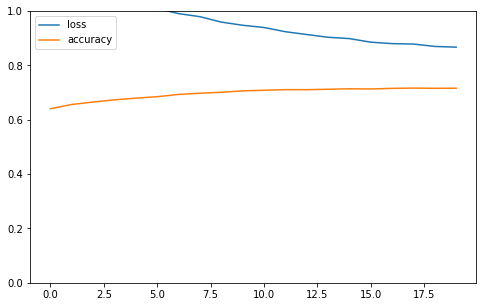

In [ ]:
pd.DataFrame(new_hist.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('new-model-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('new-model-learning-curves.png')
plt.show()

That doesn't look very good...

In [ ]:
new_model2 = build_seq_model_4(input_shape=train_std_RF.shape[1:], learning_rate=0.002)
new_hist2 = new_model2.fit(train_std_RF, y_train, batch_size=20, epochs=20)

Epoch 1/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.7438 - accuracy: 0.7302
Epoch 2/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5543 - accuracy: 0.7835
Epoch 3/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5266 - accuracy: 0.7912
Epoch 4/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5165 - accuracy: 0.7947
Epoch 5/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.5076 - accuracy: 0.7981
Epoch 6/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.5040 - accuracy: 0.8011
Epoch 7/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.4946 - accuracy: 0.8036
Epoch 8/20
8768/8768 [==============================] - 10s 1ms/step - loss: 0.4863 - accuracy: 0.8048
Epoch 9/20
8768/8768 [==============================] - 11s 1ms/step - loss: 0.4867 - accuracy: 0.8067
Epoch 10/20
8768/8768 [==============================] - 11s 1ms/step - l

In [ ]:
new_model2.save('new_model2.h5')
files.download('new_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross-val predictions and a confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import cross_val_predict

In [ ]:
new_model2_wrapped = keras.wrappers.scikit_learn.KerasClassifier(new_model2)

That doesn't work...

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# load previously built model
saved_model = files.upload() # joblib.load('./data/new_model3.pkl')

Saving new_model3.pkl to new_model3.pkl


In [ ]:
# load previously built model
new_model3 = joblib.load('new_model3.pkl')

In [ ]:
new_model3.get_params()

{'batch_size': 20,
 'build_fn': <function __main__.build_seq_model_4>,
 'epochs': 20,
 'input_shape': (50,),
 'learning_rate': 0.002,
 'verbose': 0}

In [ ]:
new_model3 = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_4, 
                                                         input_shape=train_std_RF.shape[1:], 
                                                         learning_rate=0.002, epochs=20, 
                                                         batch_size=20, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
new_model3_results = cross_val_score(new_model3, train_std_RF, y_train, cv=kfold)
print(new_model3_results.mean())

0.8080425977706909


In [ ]:
new_model3_results

array([0.80992299, 0.80803013, 0.80991215, 0.80449414, 0.81071061,
       0.80637616, 0.80506444, 0.80483633, 0.81031138, 0.81076765])

In [ ]:
y_pred_adamax = cross_val_predict(new_model3, train_std_RF, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax, class_rep_adamax, rep_dict_adamax, acc_adamax = gen_metrics(y_train, y_pred_adamax)
print(class_rep_adamax)

              precision    recall  f1-score   support

           0       0.58      0.09      0.16      2000
           1       0.40      0.01      0.02      1746
           2       0.43      0.07      0.12     12264
           3       0.61      0.91      0.73     33393
           4       0.64      0.70      0.67     18184
           5       1.00      0.98      0.99     40000
           6       0.93      0.90      0.91     56000
           7       0.82      0.74      0.78     10491
           8       0.60      0.47      0.53      1133
           9       0.56      0.04      0.07       130

    accuracy                           0.81    175341
   macro avg       0.66      0.49      0.50    175341
weighted avg       0.80      0.81      0.78    175341



In [ ]:
joblib.dump(rep_dict_adamax, 'rep_dict_ann_adamax_RF.pkl')
files.download('rep_dict_ann_adamax_RF.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
confmat_df = pd.DataFrame(conf_mat_adamax, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

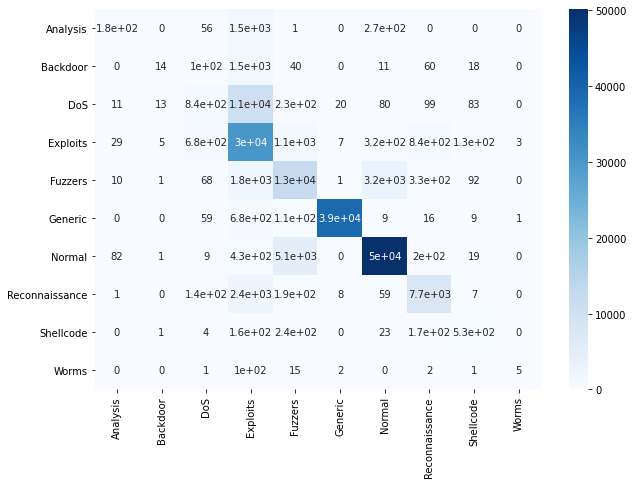

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-RF-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-RF-confmat.png')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
confmat_df_norm = pd.DataFrame(scaler.fit_transform(confmat_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

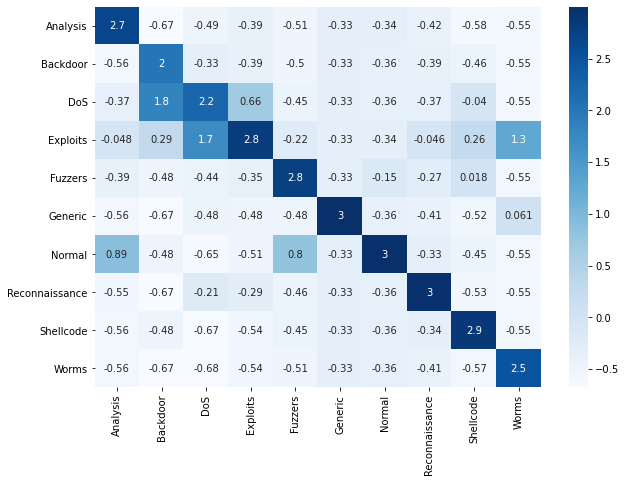

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-RF-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-RF-confmat-stdscale.png')
plt.show()

In [ ]:
joblib.dump(new_model3, 'new_model3.pkl')
files.download('new_model3.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Since we've tuned a few more hyperparameters, let's try cross-validating.

In [ ]:
# Define per-fold score containers
fold_accuracy = []
fold_loss = []

# Stratified K-Fold to avoid imbalanced class distribution for multiclassification
kfold = model_selection.StratifiedKFold(n_splits=5)

# Build and evaluate model for each fold
f_num = 1
for train, test in kfold.split(train_std_RF, y_train):
  model = build_seq_model_6(input_shape=train_std_RF.shape[1:], learning_rate=0.002,
                            activation='relu', dropout_rate=0.2, weight_constraint=3)
  print('Training fold', f_num)
  hist = model.fit(train_std_RF.iloc[train], y_train[train], batch_size=20, epochs=20, verbose=1)

  # Calculate and print accuracy and loss for fold
  scores = model.evaluate(train_std_RF.iloc[test], y_train[test], verbose=0)
  print('Fold', f_num, ':',  {model.metrics_names[0]}, '=', {scores[0]}, ';',
        {model.metrics_names[1]}, '=', {scores[1]*100}, '%')
  fold_accuracy.append(scores[1] * 100)
  fold_loss.append(scores[0])

  f_num += 1

# Print average accuracy and loss
print('Score per fold')
for i in range(0, len(fold_accuracy)):
  print('Fold', i+1, ': Loss=', fold_loss[i], '; Accuracy=', fold_accuracy[i], '%')
print('Average scores for all folds:')
print('Accuracy:', np.mean(fold_accuracy), '+-', np.std(fold_accuracy))
print('Loss:', np.mean(fold_loss))

Training fold 1
Epoch 1/20
7014/7014 [==============================] - 9s 1ms/step - loss: 1.0323 - accuracy: 0.6277
Epoch 2/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.7115 - accuracy: 0.7360
Epoch 3/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.6546 - accuracy: 0.7535
Epoch 4/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.6434 - accuracy: 0.7565
Epoch 5/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.6217 - accuracy: 0.7627
Epoch 6/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.6130 - accuracy: 0.7638
Epoch 7/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.5995 - accuracy: 0.7673
Epoch 8/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.5967 - accuracy: 0.7691
Epoch 9/20
7014/7014 [==============================] - 8s 1ms/step - loss: 0.5904 - accuracy: 0.7706
Epoch 10/20
7014/7014 [==============================] - 8s 1ms/st

I think better results should be possible. Let's try to use Optuna to see if we can find better hyperparameter values.

## Hyperparameter tuning with Optuna

In [21]:
!pip install --quiet optuna

     |████████████████████████████████| 296kB 5.8MB/s 
     |████████████████████████████████| 163kB 48.2MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 143kB 33.1MB/s 
     |████████████████████████████████| 112kB 45.4MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 


In [22]:
import optuna
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_std_RF, y_train, test_size=0.3, train_size=0.7, shuffle=True, stratify=y_train)

In [ ]:
def objective(trial):    
    # define model with Dropout layers and use trial object to suggest hyperparameter values
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1:]))
    model.add(keras.layers.Dense(48, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(36, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(24, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(16, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification

    # compile model and use trial object to suggest learning rate.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adamax(learning_rate=lr), 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
#        validation_split=0.2, shuffle=True,
        batch_size=trial.suggest_int('batch_size', 10, 50), 
        epochs=trial.suggest_int('epochs', 20, 50),
        verbose=False)
    
    # evaluate returns [loss, accuracy], but we only want accuracy
    return model.evaluate(X_valid, y_valid, verbose=0)[1]
    #X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(*arrays=[train_std_RF, y_train], test_size=0.3, train_size=0.7, shuffle=True, stratify=class_labels)

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2021-04-14 18:15:14,945] A new study created in memory with name: no-name-614a4e4b-6eb9-4ca9-bb0e-a6f18e93a13f


In [ ]:
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-14 18:18:21,251] Trial 0 finished with value: 0.3193734288215637 and parameters: {'activation': 'relu', 'weight_constraint': 3, 'rate': 0.8588630180324257, 'lr': 6.952548481843866e-05, 'batch_size': 25, 'epochs': 27}. Best is trial 0 with value: 0.3193734288215637.
[I 2021-04-14 18:20:47,865] Trial 1 finished with value: 0.750052273273468 and parameters: {'activation': 'relu', 'weight_constraint': 5, 'rate': 0.5246948712098553, 'lr': 0.0010039692235666497, 'batch_size': 31, 'epochs': 26}. Best is trial 1 with value: 0.750052273273468.
[I 2021-04-14 18:23:30,586] Trial 2 finished with value: 0.5364713072776794 and parameters: {'activation': 'tanh', 'weight_constraint': 1, 'rate': 0.7806512535882172, 'lr': 8.577406428404011e-05, 'batch_size': 36, 'epochs': 33}. Best is trial 1 with value: 0.750052273273468.
[I 2021-04-14 18:29:16,228] Trial 3 finished with value: 0.3193734288215637 and parameters: {'activation': 'relu', 'weight_constraint': 4, 'rate': 0.8287615094630013, 'lr':

Accuracy: 0.8108282685279846
Best hyperparameters: {'activation': 'relu', 'weight_constraint': 5, 'rate': 0.01745161505730783, 'lr': 0.0051450390539644385, 'batch_size': 20, 'epochs': 27}


It seems like this model is maxing out at 80% accuracy. That may be due to the skewed data set; the classes that are under-represented can't be learned and predicted as well as the others.  
Maybe providing class weights can help? It seemed to provide worse results before, but maybe we should try again?

In [ ]:
optuna.importance.get_param_importances(study)

OrderedDict([('rate', 0.9823584880326863),
             ('lr', 0.007932645809315067),
             ('activation', 0.003472559077729803),
             ('batch_size', 0.003398524299628801),
             ('weight_constraint', 0.0015165950046403121),
             ('epochs', 0.0013211877759998166)])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

[W 2021-04-15 00:32:02,607] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_slice(study)

Let's see if changing number of layers and neurons makes a difference.

In [ ]:
def objective_2(trial):    
    # use trial object to suggest num layers/neurons, other hyperparameters set from previous study
    n_layers = trial.suggest_int('n_layers', 1, 5)
    n_neurons = trial.suggest_int('n_neurons', 20, 100, 10)

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1:]))
    for _ in range(n_layers):
      model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_constraint=maxnorm(5)))
      model.add(keras.layers.Dropout(rate=0.017))

    model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification

    # compile model and use trial object to suggest learning rate.
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adamax(learning_rate=0.005), 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              batch_size=20, epochs=27,
              verbose=False)
    
    # evaluate returns [loss, accuracy], but we only want accuracy
    return model.evaluate(X_valid, y_valid, verbose=0)[1]

In [ ]:
study_2 = optuna.create_study(direction='maximize',
                              sampler=optuna.samplers.TPESampler(),
                              pruner=optuna.pruners.SuccessiveHalvingPruner())

[I 2021-04-15 23:05:19,707] A new study created in memory with name: no-name-0d5d24a6-a889-45d8-a0f5-836e0756e54f


In [ ]:
study_2.optimize(objective_2, n_trials=20)

trial_2 = study_2.best_trial

print('Accuracy: {}'.format(trial_2.value))
print("Best hyperparameters: {}".format(trial_2.params))

[I 2021-04-15 23:09:19,056] Trial 0 finished with value: 0.8127292990684509 and parameters: {'n_layers': 3, 'n_neurons': 70}. Best is trial 0 with value: 0.8127292990684509.
[I 2021-04-15 23:14:24,100] Trial 1 finished with value: 0.8156188726425171 and parameters: {'n_layers': 4, 'n_neurons': 100}. Best is trial 1 with value: 0.8156188726425171.
[I 2021-04-15 23:18:16,281] Trial 2 finished with value: 0.8123300671577454 and parameters: {'n_layers': 3, 'n_neurons': 50}. Best is trial 1 with value: 0.8156188726425171.
[I 2021-04-15 23:22:07,470] Trial 3 finished with value: 0.809440553188324 and parameters: {'n_layers': 4, 'n_neurons': 40}. Best is trial 1 with value: 0.8156188726425171.
[I 2021-04-15 23:26:42,063] Trial 4 finished with value: 0.8124251365661621 and parameters: {'n_layers': 5, 'n_neurons': 60}. Best is trial 1 with value: 0.8156188726425171.
[I 2021-04-15 23:30:01,482] Trial 5 finished with value: 0.8054863810539246 and parameters: {'n_layers': 2, 'n_neurons': 30}. Best

Accuracy: 0.8156188726425171
Best hyperparameters: {'n_layers': 4, 'n_neurons': 100}


It's looking like a large number of neurons might improve results, but not by much.  We set the high value at 100, maybe we should search higher?

### All features

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(training_data_std, y_train, test_size=0.3, train_size=0.7, shuffle=True, stratify=y_train)

In [27]:
X_train.shape

(122738, 194)

In [28]:
def objective_3(trial):
  # use trial object to suggest num layers/neurons, other hyperparameters set from previous study 
    n_layers = trial.suggest_int('n_layers', 2, 5)
    n_neurons = trial.suggest_int('n_neurons', 200, 300, 10)
    act = trial.suggest_categorical('activation', ['relu', 'tanh'])
    weight_constraint = trial.suggest_int('weight_constraint', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.9)
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    bat_sz = trial.suggest_int('batch_size', 10, 50)
    epch = trial.suggest_int('epochs', 20, 50)

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1:]))
    for _ in range(n_layers):
      model.add(keras.layers.Dense(n_neurons, 
                                   activation=act,
                                   kernel_constraint=maxnorm(weight_constraint)))
      model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification

    # compile model and use trial object to suggest learning rate.
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adamax(learning_rate=lr), 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              batch_size=bat_sz, 
              epochs=epch,
              callbacks=optuna.integration.KerasPruningCallback(trial, 'val_accuracy'),
              verbose=False)
    
    # evaluate returns [loss, accuracy], but we only want accuracy
    return model.evaluate(X_valid, y_valid, verbose=0)[1]

In [29]:
study_3 = optuna.create_study(direction='maximize',
                              sampler=optuna.samplers.TPESampler(),
                              pruner=optuna.pruners.SuccessiveHalvingPruner())

[I 2021-04-16 22:26:01,621] A new study created in memory with name: no-name-78fbdc37-f69d-4680-ad66-649971d97a6a


In [30]:
study_3.optimize(objective_3, n_trials=100, timeout=7200, n_jobs=-1)

trial_3 = study_3.best_trial

print('Accuracy: {}'.format(trial_3.value))
print("Best hyperparameters: {}".format(trial_3.params))

/usr/local/lib/python3.7/dist-packages/optuna/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0

[I 2021-04-16 22:50:50,915] Trial 1 finished with value: 0.7680550813674927 and parameters: {'n_layers': 4, 'n_neurons': 270, 'activation': 'relu', 'weight_constraint': 1, 'dropout_rate': 0.7625020349924848, 'learning_rate': 0.0031

Accuracy: 0.8164363503456116
Best hyperparameters: {'n_layers': 2, 'n_neurons': 270, 'activation': 'relu', 'weight_constraint': 2, 'dropout_rate': 0.10554484065920965, 'learning_rate': 0.0022977776076957227, 'batch_size': 49, 'epochs': 38}


Trial output out of order due to parallelization.

In [40]:
study_3.best_trials

[FrozenTrial(number=2, values=[0.8164363503456116], datetime_start=datetime.datetime(2021, 4, 16, 22, 50, 50, 922216), datetime_complete=datetime.datetime(2021, 4, 16, 23, 0, 48, 959139), params={'n_layers': 2, 'n_neurons': 270, 'activation': 'relu', 'weight_constraint': 2, 'dropout_rate': 0.10554484065920965, 'learning_rate': 0.0022977776076957227, 'batch_size': 49, 'epochs': 38}, distributions={'n_layers': IntUniformDistribution(high=5, low=2, step=1), 'n_neurons': IntUniformDistribution(high=300, low=200, step=10), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'weight_constraint': IntUniformDistribution(high=5, low=1, step=1), 'dropout_rate': UniformDistribution(high=0.9, low=0.0), 'learning_rate': LogUniformDistribution(high=0.1, low=1e-05), 'batch_size': IntUniformDistribution(high=50, low=10, step=1), 'epochs': IntUniformDistribution(high=50, low=20, step=1)}, user_attrs={}, system_attrs={'completed_rung_0': 0.7889474034309387, 'completed_rung_1': 0.80099993944

In [45]:
df = study_3.trials_dataframe()
df.sort_values(by='value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_dropout_rate,params_epochs,params_learning_rate,params_n_layers,params_n_neurons,params_weight_constraint,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,state
2,2,0.816436,2021-04-16 22:50:50.922216,2021-04-16 23:00:48.959139,0 days 00:09:58.036923,relu,49,0.105545,38,0.002298,2,270,2,0.788947,0.801000,0.811342,COMPLETE
7,7,0.816246,2021-04-16 22:55:16.565820,2021-04-16 23:21:22.046267,0 days 00:26:05.480447,relu,31,0.083546,29,0.003033,5,300,2,0.792407,0.802635,0.816094,COMPLETE
58,58,0.815923,2021-04-17 00:02:05.573505,2021-04-17 00:09:25.851624,0 days 00:07:20.278119,relu,30,0.043483,43,0.001966,4,230,2,0.797426,0.803015,0.815923,PRUNED
52,52,0.815676,2021-04-16 23:52:19.532182,2021-04-16 23:59:55.897731,0 days 00:07:36.365549,relu,34,0.036383,48,0.002117,4,220,2,0.792807,0.803718,0.815676,PRUNED
64,64,0.814992,2021-04-17 00:10:42.878945,2021-04-17 00:17:01.474697,0 days 00:06:18.595752,relu,34,0.035167,40,0.002918,4,220,2,0.794955,0.805030,0.814992,PRUNED


In [31]:
study_3.best_value

0.8164363503456116

In [32]:
study_3.best_params

{'activation': 'relu',
 'batch_size': 49,
 'dropout_rate': 0.10554484065920965,
 'epochs': 38,
 'learning_rate': 0.0022977776076957227,
 'n_layers': 2,
 'n_neurons': 270,
 'weight_constraint': 2}

In [33]:
optuna.importance.get_param_importances(study_3)

OrderedDict([('learning_rate', 0.22727272727272702),
             ('weight_constraint', 0.20454545454545434),
             ('batch_size', 0.15909090909090956),
             ('dropout_rate', 0.15909090909090892),
             ('n_layers', 0.11363636363636404),
             ('epochs', 0.11363636363636351),
             ('n_neurons', 0.022727272727272704),
             ('activation', 0.0)])

In [34]:
optuna.visualization.plot_param_importances(study_3)

In [35]:
optuna.visualization.plot_intermediate_values(study_3)

In [36]:
optuna.visualization.plot_slice(study_3)

As with the other feature subsets, the full feature set seems to achieve about 81% accuracy.